Train a detectron2 model on a custom fire dataset


# Install detectron2

In [1]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.5.1+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (colab has CUDA 10.1 + torch 1.5)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.5")
!pip install detectron2==0.2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Train on a custom dataset

## Prepare the dataset

In [ ]:
# download, decompress the data
!wget https://www.dropbox.com/s/3qr34nonhvq3syc/fire-dataset.zip
!unzip "*.zip" 

In [5]:
import xml.etree.ElementTree as ET
from detectron2.structures import BoxMode

def load_voc_instances(data_dir, class_names):
    """
    Load Pascal VOC detection annotations to Detectron2 format.
    Args:
        dirname: Contain "annotations", "images"
    """
    file_ids = [os.path.splitext(filename)[0] for filename in os.listdir(os.path.join(data_dir, "annotations"))]

    dicts = []
    for file_id in file_ids:
        anno_file = os.path.join(data_dir, "annotations", file_id + ".xml")
        jpeg_file = os.path.join(data_dir, "images", file_id + ".jpg")

        tree = ET.parse(anno_file)

        r = {
            "file_name": jpeg_file,
            "image_id": file_id,
            "height": int(tree.findall("./size/height")[0].text),
            "width": int(tree.findall("./size/width")[0].text),
        }
        instances = []

        for obj in tree.findall("object"):
            cls = obj.find("name").text
            bbox = obj.find("bndbox")
            bbox = [float(bbox.find(x).text) for x in ["xmin", "ymin", "xmax", "ymax"]]
            # Original annotations are integers in the range [1, W or H]
            # Assuming they mean 1-based pixel indices (inclusive),
            # a box with annotation (xmin=1, xmax=W) covers the whole image.
            # In coordinate space this is represented by (xmin=0, xmax=W)
            bbox[0] -= 1.0
            bbox[1] -= 1.0
            instances.append(
                {"category_id": class_names.index(cls), "bbox": bbox, "bbox_mode": BoxMode.XYXY_ABS}
            )
        r["annotations"] = instances
        dicts.append(r)
    return dicts

DATA_DIR = '/content/fire-dataset'
CLASS_NAMES=['fire']

for d in ["train", "validation"]:
    DatasetCatalog.register("fire_" + d, lambda d=d: load_voc_instances(os.path.join(DATA_DIR, d), CLASS_NAMES))
    MetadataCatalog.get("fire_" + d).set(thing_classes=CLASS_NAMES)
fire_metadata = MetadataCatalog.get("fire_train")

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



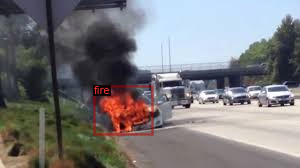

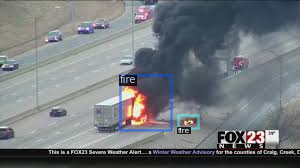

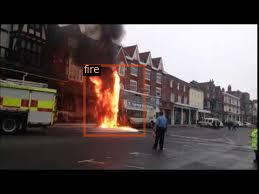

In [6]:
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt

dataset_dicts =  load_voc_instances(os.path.join(DATA_DIR, 'train'), CLASS_NAMES)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=fire_metadata, scale=1.)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

## Train

Fine-tune a COCO-pretrained model on the fire dataset.


In [7]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("fire_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.SOLVER.BASE_LR = 0.00025  
cfg.SOLVER.MAX_ITER = 500   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster(default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (fire)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[07/29 09:39:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:15, 10.9MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.


[07/29 09:40:22 d2.engine.train_loop]: Starting training from iteration 0
[07/29 09:40:46 d2.utils.events]:  eta: 0:09:59  iter: 19  total_loss: 1.097  loss_cls: 0.528  loss_box_reg: 0.517  loss_rpn_cls: 0.020  loss_rpn_loc: 0.009  time: 1.1867  data_time: 0.0158  lr: 0.000400  max_mem: 2735M
[07/29 09:41:10 d2.utils.events]:  eta: 0:09:16  iter: 39  total_loss: 0.715  loss_cls: 0.280  loss_box_reg: 0.426  loss_rpn_cls: 0.024  loss_rpn_loc: 0.008  time: 1.1855  data_time: 0.0090  lr: 0.000799  max_mem: 2735M
[07/29 09:41:33 d2.utils.events]:  eta: 0:08:53  iter: 59  total_loss: 0.784  loss_cls: 0.206  loss_box_reg: 0.511  loss_rpn_cls: 0.020  loss_rpn_loc: 0.008  time: 1.1726  data_time: 0.0084  lr: 0.001199  max_mem: 2735M
[07/29 09:41:58 d2.utils.events]:  eta: 0:08:33  iter: 79  total_loss: 0.705  loss_cls: 0.219  loss_box_reg: 0.480  loss_rpn_cls: 0.012  loss_rpn_loc: 0.007  time: 1.1932  data_time: 0.0061  lr: 0.001598  max_mem: 2735M
[07/29 09:42:22 d2.utils.events]:  eta: 0:08:0

In [8]:
# # Look at training curves in tensorboard:
# %load_ext tensorboard
# %tensorboard --logdir output

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [9]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # a custom testing threshold 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (fire)
# cfg.DATASETS.TEST = ("fire_validation", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

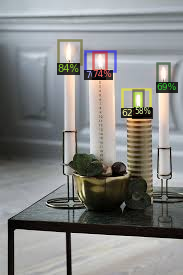

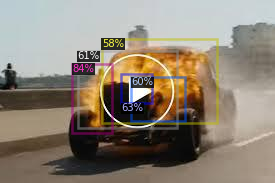

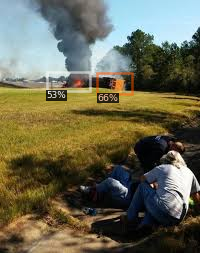

In [14]:
dataset_dicts = load_voc_instances(os.path.join(DATA_DIR, 'validation'), CLASS_NAMES)
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1])
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70. Not bad!

In [11]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("fire_validation", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "fire_validation")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way is to use trainer.test

[07/29 09:50:32 d2.evaluation.coco_evaluation]: 'fire_validation' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[07/29 09:50:32 d2.data.datasets.coco]: Converting annotations of dataset 'fire_validation' to COCO format ...)
[07/29 09:50:32 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[07/29 09:50:32 d2.data.datasets.coco]: Conversion finished, #images: 90, #annotations: 138
[07/29 09:50:32 d2.data.datasets.coco]: Caching COCO format annotations at './output/fire_validation_coco_format.json' ...
[07/29 09:50:32 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    fire    | 138          |
|            |              |
[07/29 09:50:32 d2.data.common]: Serializing 90 elements to byte tensors and concatenating them all ...
[07/29 09:50:32 d2.data.common]: Serialized dataset takes 0.03 MiB
[07/29 09:50:32 d2.data.dataset_mapper]: Augmentations

# Demo on test video

In [25]:
# Install dependencies, download the video, and crop 5 seconds for processing
!pip uninstall -y opencv-python-headless opencv-contrib-python
!apt install python3-opencv  # the one pre-installed have some issues
!wget https://www.dropbox.com/s/ykrol6xws7kolt3/FireOnRoad.mp4
!ffmpeg -i FireOnRoad.mp4 -t 00:00:06 -c:v copy video-clip.mp4

Uninstalling opencv-contrib-python-4.1.2.30:
  Successfully uninstalled opencv-contrib-python-4.1.2.30
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  python3-opencv
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 534 kB of archives.
After this operation, 2,941 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 python3-opencv amd64 3.2.0+dfsg-4ubuntu0.1 [534 kB]
Fetched 534 kB in 2s (265 kB/s)
Selecting previously unselected package python3-opencv.
(Reading database ... 144465 files and directories currently installed.)
Preparing to unpack .../python3-opencv_3.2.0+dfsg-4ubuntu0.1_amd64.deb ...
Unpacking python3-opencv (3.2.0+dfsg-4ubuntu0.1) ...
Setting up python3-opencv (

In [37]:
# Run frame-by-frame inference demo on this video (takes 3-4 minutes) with the "demo.py" 
!git clone https://github.com/DenisRang/Fire-detection-Detectron2
!python Fire-detection-Detectron2/demo.py --config-file COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml \
  --video-input video-clip.mp4 --confidence-threshold 0.5 --output video-output.mkv --opts MODEL.WEIGHTS /content/output/model_final.pth

Cloning into 'Fire-detection-Detectron2'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4 (delta 0), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
Failed to load OpenCL runtime
[07/28 09:58:30 detectron2]: Arguments: Namespace(confidence_threshold=0.5, config_file='COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml', opts=['MODEL.WEIGHTS', '/content/output/model_final.pth'], output='video-output.mkv', video_input='video-clip.mp4')
  0% 0/203 [00:00<?, ?it/s][07/28 09:58:33 fvcore.common.checkpoint]: Loading checkpoint from /content/output/model_final.pth
100% 203/203 [01:20<00:00,  2.52it/s]


In [2]:
# Download the results
from google.colab import files
# files.download('video-clip.mp4')
files.download('video-output.mkv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
f = open("data.yaml", "w")
f.write(cfg.dump())
f.close()

In [18]:
!pip install onnx
!python Fire-detection-Detectron2/caffe2_converter.py --config-file /content/data.yaml \
	--output ./onnx_model --run-eval --format onnx \
	MODEL.WEIGHTS /content/output/model_final.pth \
	MODEL.DEVICE cpu

[07/29 09:56:16 detectron2]: Command line arguments: Namespace(config_file='/content/data.yaml', format='onnx', opts=['MODEL.WEIGHTS', '/content/output/model_final.pth', 'MODEL.DEVICE', 'cpu'], output='./onnx_model', run_eval=True)
[07/29 09:56:17 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    fire    | 138          |
|            |              |
[07/29 09:56:17 d2.data.common]: Serializing 90 elements to byte tensors and concatenating them all ...
[07/29 09:56:17 d2.data.common]: Serialized dataset takes 0.03 MiB
[07/29 09:56:17 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
/usr/local/lib/python3.6/dist-packages/torch/onnx/utils.py:209: UserWarning: `add_node_names' can be set to True only when 'operator_export_type' is `ONNX`. Since 'operator_export_type' is not set to 'ONNX', `add_node_names` argument